identification of Dopimanergic Neurons in Substantia Nigra using ASAP CRN scnRNA cohort data.


In [1]:
import sys, subprocess, importlib, warnings, math, os, pandas as pd, gc
from pathlib import Path

def setup_environment():
    """Configure logging, warnings, pandas options, and auto-install core packages."""

    def import_or_install(pkg, import_name=None, version=None):
        try:
            return importlib.import_module(import_name or pkg)
        except ImportError:
            install_str = pkg if version is None else f"{pkg}{version}"
            print(f"{pkg} not found. Installing {install_str}...")
            subprocess.run([sys.executable, "-m", "pip", "install", install_str], check=True)
            return importlib.import_module(import_name or pkg)

    env = {
        "pd": pd,
        "np": import_or_install("numpy", version="<2"), #version <2 for tensorflow compatibility
        "plt": import_or_install("matplotlib", "matplotlib.pyplot"),
        "sns": import_or_install("seaborn"),
        "Image": import_or_install("Pillow", "PIL.Image"),
        "sc": import_or_install("scanpy")
    }

    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", 1200)

    print("Environment ready.")
    return env

In [2]:
env = setup_environment()
pd, np, plt, sns, Image, sc  = (
    env["pd"], env["np"], env["plt"], env["sns"],
    env["Image"], env["sc"]
)


Environment ready.


In [3]:
# Install scikit-misc
%pip install scikit-misc
# Pin NumPy to <2
%pip install "numpy<2"
# Uninstall hail
%pip uninstall -y hail

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
np.__version__

'1.26.4'

## 1. Workspace Setup

### 1.1 Set dataset paths
In this example, we are working with the **PMDBS single‑cell RNA‑seq cohort** dataset:

- **Workflow** → `pmdbs_sc_rnaseq`  
- **Team** → `cohort`  
- **Source** → `pmdbs`  
- **Type** → `sc-rnaseq`  

These components are combined to construct the bucket and dataset names.  
We then set the path to the **cohort analysis outputs** and preview the available files.


In [5]:
#set general folder paths
HOME = Path.home()
WS_ROOT = HOME / "workspace"
DATA_DIR = WS_ROOT / "Data"
WS_FILES = WS_ROOT / "ws_files"

if not WS_ROOT.exists():
    print(f"{WS_ROOT} doesn't exist. We need to remount our resources")
    !wb resource mount    

print("Home directory:     ", HOME)
print("Workspace root:     ", WS_ROOT)
print("Data directory:     ", DATA_DIR)
print("ws_files directory: ", WS_FILES)

print("\nContents of workspace root:")
for p in WS_ROOT.glob("*"):
    print(" -", p.name, "/" if p.is_dir() else "")

Home directory:      /home/jupyter
Workspace root:      /home/jupyter/workspace
Data directory:      /home/jupyter/workspace/Data
ws_files directory:  /home/jupyter/workspace/ws_files

Contents of workspace root:
 - Documentation /
 - ws_files /
 - 01_PMDBS_scRNAseq /
 - 02_PMDBS_bulkRNAseq /
 - 05_Other_Datasets /
 - 03_PMDBS_Spatial /
 - release_resources /
 - 04_Mouse_Spatial /


In [6]:
## Build and set path to desired dataset

DATASETS_PATH = WS_ROOT / "01_PMDBS_scRNAseq"

workflow       = "pmdbs_sc_rnaseq"
dataset_team   = "cohort"
dataset_source = "pmdbs"
dataset_type   = "sc-rnaseq"

bucket_name  = f"asap-curated-{dataset_team}-{dataset_source}-{dataset_type}"
dataset_name = f"asap-{dataset_team}-{dataset_source}-{dataset_type}"

dataset_path = DATASETS_PATH / bucket_name / workflow
print("Dataset Path:", dataset_path)

# Build the folder path to the cohort analysis directory
cohort_analysis_path = dataset_path / "cohort_analysis"

# Preview the directory contents
print("Contents of cohort_analysis:")
!ls {cohort_analysis_path}

Dataset Path: /home/jupyter/workspace/01_PMDBS_scRNAseq/asap-curated-cohort-pmdbs-sc-rnaseq/pmdbs_sc_rnaseq
Contents of cohort_analysis:
asap-cohort.all_genes.csv
asap-cohort.doublet_score.violin.png
asap-cohort.features.umap.png
asap-cohort.final.h5ad
asap-cohort.final_metadata.csv
asap-cohort.groups.umap.png
asap-cohort.hvg_genes.csv
asap-cohort.merged_cleaned_unfiltered.h5ad
asap-cohort.mmc_otf_mapping.SEAAD.extended_results.json
asap-cohort.mmc_otf_mapping.SEAAD.log.txt
asap-cohort.mmc_otf_mapping.SEAAD.results.csv
asap-cohort.mmc_results.parquet
asap-cohort.n_genes_by_counts.violin.png
asap-cohort.pct_counts_mt.violin.png
asap-cohort.pct_counts_rb.violin.png
asap-cohort.sample_list.tsv
asap-cohort.scanvi_cell_types.parquet
asap-cohort.scanvi_model.tar.gz
asap-cohort.scib_report.csv
asap-cohort.scib_results.svg
asap-cohort.scvi_model.tar.gz
asap-cohort.total_counts.violin.png
MANIFEST.tsv


In [7]:
# Define a local path for workshop files
local_data_path = WS_FILES / "case_study_01"

# Create the directory if it doesn't already exist
if not local_data_path.exists():
    local_data_path.mkdir(parents=True)

print(f"Local data directory ready at: {local_data_path}")

Local data directory ready at: /home/jupyter/workspace/ws_files/case_study_01


### Copy Data Locally

We now bring in the curated dataset files:

- **`asap-cohort.final_metadata.csv`** → cell‑level metadata table
- **`asap-cohort.final.h5ad`** → full AnnData object containing HVG expression data and annotations  

We copy these files into our local `pilot_workshop_files` directory (if not already present) and load them into memory.

The metadata CSV is read into a Pandas dataframe, while the `.h5ad` file is loaded as an AnnData object in backed mode.

In [8]:
# Downloading obs field (cell metadata)
# Define the expected local path for the metadata file.
cell_metadata_local_path = local_data_path / f"asap-{dataset_team}.final_metadata.csv"\

# Check if the metadata file already exists locally.
if not cell_metadata_local_path.exists():
    # Construct the original path where the metadata file is stored.
    cell_metadata_og_path = cohort_analysis_path / f"asap-{dataset_team}.final_metadata.csv"

    # Use a shell command (`cp`) to copy the file from the original location
    # into the local workshop_files directory for analysis.
    !cp {cell_metadata_og_path} {cell_metadata_local_path}

In [9]:
# Downloading the anndata object
# Define the expected local path
adata_local_path = local_data_path / f"asap-{dataset_team}.final.h5ad"

# Check if the adata file already exists locally.
if not adata_local_path.exists():
    # Construct the original path where the metadata file is stored.
    adata_cell_metadata_og_path = cohort_analysis_path / f"asap-{dataset_team}.final.h5ad"

    # Use a shell command (`cp`) to copy the file from the original location
    # into the local workshop_files directory for analysis.
    !cp {adata_cell_metadata_og_path} {adata_local_path}

# load the adata object
adata = sc.read_h5ad(adata_local_path, backed="r")
adata

AnnData object with n_obs × n_vars = 3046127 × 3000 backed at '/home/jupyter/workspace/ws_files/case_study_01/asap-cohort.final.h5ad'
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', 'cell_type', 'phenotype', 'rho', 'prob', 'class_name', 'subclass_name', 'supertype_name', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'log1p', 'neighbors', 'pca', 'scrublet',

### Metadata Access & Integration 

In [10]:
#Define metadata folder path
ds_metadata_path = WS_ROOT / "release_resources/cohort-pmdbs-sc-rnaseq/metadata"

#preview contents
!ls {ds_metadata_path} 

ASSAY_RNAseq.csv  collection_version  PMDBS.csv     STUDY.csv
cde_version	  CONDITION.csv       PROTOCOL.csv  SUBJECT.csv
CLINPATH.csv	  DATA.csv	      SAMPLE.csv


In [11]:
# study-level metadata
STUDY = pd.read_csv(ds_metadata_path / "STUDY.csv", index_col = 0)
STUDY[["ASAP_team_id" , "dataset_name","sample_types"]]

#definitely team Lee

,ASAP_team_id,dataset_name,sample_types
0,TEAM_HAFLER,Single-cell transcriptomic and proteomic analy...,Prefrontal cortex
1,TEAM_LEE,Single nucleus RNA-sequencing of human postmor...,hippocampus; middle frontal gyrus; substantia ...
2,TEAM_JAKOBSSON,NaN,sc-rnaseq
3,TEAM_SCHERZER,NaN,MTG
4,TEAM_HARDY,Single-nucleus RNA sequencing of human post-mo...,"Inferior Parietal Lobule (IPL), Anterior Cingu..."


In [12]:
# Sample-level metadata
SAMPLE = pd.read_csv(ds_metadata_path / "SAMPLE.csv", index_col=0)
# Subject-level metadata
SUBJECT = pd.read_csv(ds_metadata_path / "SUBJECT.csv", index_col=0)
#  Brain-sample metadata
PMDBS = pd.read_csv(ds_metadata_path / "PMDBS.csv", index_col=0)
# Experimental condition metadata
CONDITION = pd.read_csv(ds_metadata_path / "CONDITION.csv", index_col=0)

# Select Relevant Columns
sample_cols = [
    "ASAP_sample_id",
    "ASAP_subject_id",
    "ASAP_team_id",
    "ASAP_dataset_id",
     "subject_id",
    "replicate",
    "condition_id",
    "age_at_collection"
]
subject_cols = [
    "ASAP_dataset_id",
    "ASAP_subject_id",
    "subject_id",
    "source_subject_id",
    "sex",
    "biobank_name",
    "primary_diagnosis",
]
pmdbs_cols = [
    "ASAP_sample_id",
    "brain_region",
    "region_level_1",
    "region_level_2",
    "region_level_3",
]
condition_cols = [
    "ASAP_team_id",
    "ASAP_dataset_id",
    "condition_id",
    "intervention_name",
    "intervention_id",
    "protocol_id",
]

## Evaluating datasets with SN samples

relevant datasets: 
- team Lee
- team Jakobsson

In [13]:
print("SAMPLE cols: \n", SAMPLE.columns, "\n", "\n SUBJECT cols: \n",
      SUBJECT.columns,  "\n", " \n CONDITION cols: \n", CONDITION.columns, "\n", "\n  PMDBS cols: \n", PMDBS.columns)

SAMPLE cols: 
 Index(['ASAP_team_id', 'ASAP_dataset_id', 'ASAP_sample_id', 'ASAP_subject_id', 'sample_id', 'subject_id', 'source_sample_id', 'replicate', 'replicate_count', 'repeated_sample', 'batch', 'organism', 'tissue', 'assay_type', 'condition_id', 'organism_ontology_term_id', 'age_at_collection', 'time', 'alternate_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'donor_id', 'pm_PH', 'cell_type_ontology_term_id', 'source_RIN', 'DV200', 'suspension_type'], dtype='object') 
 
 SUBJECT cols: 
 Index(['ASAP_team_id', 'ASAP_dataset_id', 'ASAP_subject_id', 'subject_id', 'source_subject_id', 'biobank_name', 'sex', 'race', 'primary_diagnosis', 'gp2_phenotype', 'primary_diagnosis_text'], dtype='object') 
  
 CONDITION cols: 
 Index(['ASAP_team_id', 'ASAP_dataset_id', 'condition_id', 'intervention_name', 'intervention_id', 'protocol_id', 'interventio

In [14]:
PMDBS[["ASAP_team_id","region_level_2"]].value_counts()

ASAP_team_id    region_level_2          
TEAM_SCHERZER   Middle temporal gyrus       97
TEAM_HARDY      Inferior parietal lobule    64
                Anterior cingulate gyrus    64
TEAM_JAKOBSSON  Putamen                     37
                Substantia nigra            34
                Amygdala                    34
TEAM_LEE        Middle frontal gyrus        25
                Substantia nigra            25
                CA1-CA4                     25
TEAM_JAKOBSSON  Prefrontal cortex           20
TEAM_HAFLER     Prefrontal cortex           12
Name: count, dtype: int64

In [15]:
#validating sample ID is unique
PMDBS.duplicated(subset="ASAP_sample_id").sum()
print(len(PMDBS[PMDBS["region_level_2"]== "Substantia nigra"]), "SN samples out of" ,len(PMDBS), "total samples")

59 SN samples out of 459 total samples


In [16]:
#some scherzer sample have NA for condition but filled intervention_id 
CONDITION["condition_id"] = CONDITION["condition_id"].fillna(CONDITION["intervention_id"])

In [17]:

df = pd.merge(
    SAMPLE[sample_cols],
    CONDITION[condition_cols],
    on=["ASAP_dataset_id","ASAP_team_id", "condition_id"],
    how="left",          # keep all SAMPLE rows, add CONDITION info
    validate="many_to_many"  # each SAMPLE row maps to one CONDITION row
)

df = pd.merge(
    df,
    SUBJECT[subject_cols],
    on=["ASAP_subject_id", "ASAP_dataset_id", "subject_id"],
    how="left",          # keep all SAMPLE rows, add SUBJECT info
    validate="many_to_many"  # each SUBJECT row maps to multiple SAMPLE rows
)

# Merge in brain-region information
df = pd.merge(df, 
              PMDBS[pmdbs_cols], 
              on=["ASAP_sample_id"], 
              how="left", 
              validate = "many_to_many" )

# create unique sample identifier
df["sample"] = df["ASAP_sample_id"] + "_" + df["replicate"]


In [18]:
df.head()

,ASAP_sample_id,ASAP_subject_id,ASAP_team_id,ASAP_dataset_id,subject_id,replicate,condition_id,age_at_collection,intervention_name,intervention_id,protocol_id,source_subject_id,sex,biobank_name,primary_diagnosis,brain_region,region_level_1,region_level_2,region_level_3,sample
0,ASAP_PMBDS_000026_s001,ASAP_PMBDS_000026,TEAM_HAFLER,DS_PMDBS_0002,HC01,Rep1,Control,81.0,Case-Control,NaN,NaN,hSDG07,Female,NKI/NYUGSOM,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000026_s001_Rep1
1,ASAP_PMBDS_000027_s001,ASAP_PMBDS_000027,TEAM_HAFLER,DS_PMDBS_0002,HC02,Rep1,Control,65.0,Case-Control,NaN,NaN,hSDG13,Female,NKI/NYUGSOM,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000027_s001_Rep1
2,ASAP_PMBDS_000028_s001,ASAP_PMBDS_000028,TEAM_HAFLER,DS_PMDBS_0002,HC03,Rep1,Control,72.0,Case-Control,NaN,NaN,hSDG101,Female,NKI/NYUGSOM,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000028_s001_Rep1
3,ASAP_PMBDS_000029_s001,ASAP_PMBDS_000029,TEAM_HAFLER,DS_PMDBS_0002,HC04,Rep1,Control,70.0,Case-Control,NaN,NaN,hSDG10,Male,NKI/NYUGSOM,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000029_s001_Rep1
4,ASAP_PMBDS_000030_s001,ASAP_PMBDS_000030,TEAM_HAFLER,DS_PMDBS_0002,HC05,Rep1,Control,63.0,Case-Control,NaN,NaN,hSDG30,Male,NKI/NYUGSOM,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000030_s001_Rep1


In [19]:
df[["ASAP_team_id","brain_region", "region_level_2"]].value_counts()
#why does team lee have substantia nigra and MFG associated with the same sample

ASAP_team_id    brain_region           region_level_2          
TEAM_SCHERZER   Middle temporal gyrus  Middle temporal gyrus       97
TEAM_HARDY      IPL                    Inferior parietal lobule    71
                ACG                    Anterior cingulate gyrus    67
TEAM_JAKOBSSON  Putamen                Putamen                     37
                Substantia nigra       Substantia nigra            34
                Amygdala               Amygdala                    34
TEAM_LEE        MFG                    Middle frontal gyrus        25
                                       Substantia nigra            25
                                       CA1-CA4                     25
TEAM_JAKOBSSON  Prefrontal cortex      Prefrontal cortex           20
TEAM_HAFLER     Prefrontal Cortex      Prefrontal cortex           12
Name: count, dtype: int64

In [20]:
# Recode brain region to be "PFC", "MFG", "HIP", "SN", "ACG", "IPL, "AMG", "PUT"
brain_fix = {
    "Prefrontal Cortex": "PFC",
    "Middle_Frontal_Gyrus": "MFG",
    "Hippocampus": "HIP",
    "Substantia_Nigra ": "SN",
    "ACG": "ACG",
    "IPL": "IPL",
    "Middle temporal gyrus": "MTG",
    "Substantia nigra": "SN",
    "Prefrontal cortex": "PFC",
    "Amygdala": "AMG",
    "Putamen": "PUT",
}
df["brain_region"] = df["brain_region"].map(brain_fix)

In [21]:
# Map to find more course designations
brain_simple = {
    "PFC": "frontal_ctx",
    "MFG": "frontal_ctx",
    "ACG": "cingulate_ctx",
    "IPL": "parietal_ctx",
    "MTG": "temporal_ctx",
    "HIP": "subcortical",
    "AMG": "subcortical",
    "PUT": "subcortical",
    "SN": "subcortical",
}

df["brain_region_simple"] = df["brain_region"].map(brain_simple)


# Define sample to match
br_mapper_full = dict(zip(df["sample"], df["brain_region"]))
br_mapper_simple = dict(zip(df["sample"], df["brain_region"].map(brain_simple)))

# Parkinsons and control samples
condition_id_mapper = dict(zip(df["sample"], df["condition_id"]))
case_id_mapper = dict(zip(df["sample"], df["intervention_name"]))

# Detailed brain region mapper 
region_1_mapper = dict(zip(df["sample"], df["region_level_1"]))
region_2_mapper = dict(zip(df["sample"], df["region_level_2"]))

# Diagnoses
diagnoses_mapper = dict(zip(df["sample"], df["primary_diagnosis"]))

#dataset metadata
dataset_mapper = dict(zip(df["sample"], df["ASAP_dataset_id"]))
biobank_mapper = dict(zip(df["sample"], df["biobank_name"]))

In [22]:
dataset_metadata_filen = local_data_path / "asap-cohort-dataset-metadata.csv"
df.to_csv(dataset_metadata_filen)

In [23]:
df[df["region_level_2"] == "Substantia nigra"][["ASAP_team_id", "ASAP_dataset_id"]].value_counts()

ASAP_team_id    ASAP_dataset_id
TEAM_JAKOBSSON  DS_PMDBS_0004      34
TEAM_LEE        DS_PMDBS_0001      25
Name: count, dtype: int64

In [24]:
df[df["region_level_2"] == "Substantia nigra"][["ASAP_team_id", "biobank_name"]].value_counts()

ASAP_team_id    biobank_name                        
TEAM_JAKOBSSON  Cambridge Brain Bank                    34
TEAM_LEE        Banner Sun Health Research Institute    25
Name: count, dtype: int64

In [25]:
# Map samples to metadata
adata.obs["brain_region"] = adata.obs["sample"].map(br_mapper_full)
adata.obs["brain_region_simple"] = adata.obs["sample"].map(br_mapper_simple)
adata.obs["case_id"] = adata.obs["sample"].map(case_id_mapper)
adata.obs["condition_id"] = adata.obs["sample"].map(condition_id_mapper)
adata.obs["region_level_1"] = adata.obs["sample"].map(region_1_mapper)
adata.obs["region_level_2"] = adata.obs["sample"].map(region_2_mapper)
adata.obs["dataset_id"] = adata.obs["sample"].map(dataset_mapper)
adata.obs["biobank_name"] = adata.obs["sample"].map(biobank_mapper)

## Subset for Substantia Nigra + Neuronal Cells

In [26]:
# identify substantia nigra cells
sn_cells = adata.obs["region_level_2"] == "Substantia nigra"
# Final boolean mask for subsetting
include = sn_cells
print(sn_cells.sum())

258505


In [27]:
# Create SN subset
sn_ad = adata[include].to_memory()
adata.file.close()  # close the original adata file

In [28]:
sn_ad.obs[["dataset_id", "biobank_name", "condition_id", "region_level_2"]].value_counts()

dataset_id     biobank_name                          condition_id  region_level_2  
DS_PMDBS_0001  Banner Sun Health Research Institute  PD            Substantia nigra    80164
DS_PMDBS_0004  Cambridge Brain Bank                  Control       Substantia nigra    71928
DS_PMDBS_0001  Banner Sun Health Research Institute  Control       Substantia nigra    53637
DS_PMDBS_0004  Cambridge Brain Bank                  PD            Substantia nigra    52776
Name: count, dtype: int64

In [29]:
sn_ad.obs[["class_name"]].value_counts()

class_name                 
Non-neuronal and Non-neural    221589
Neuronal: GABAergic             31253
Neuronal: Glutamatergic          5663
Name: count, dtype: int64

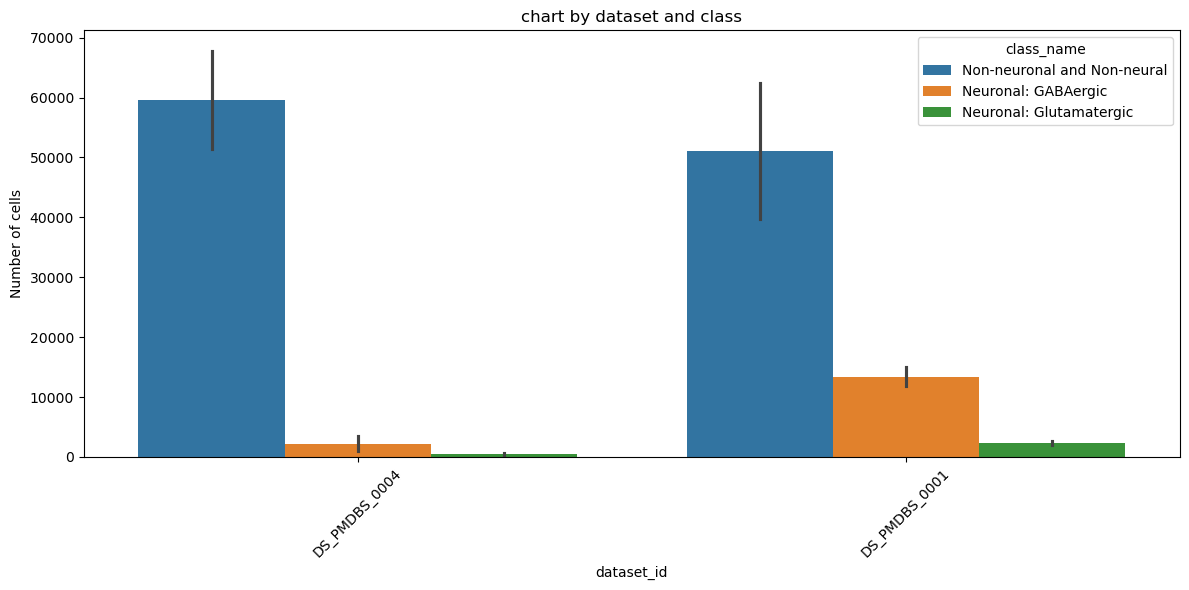

In [30]:
df = sn_ad.obs[["dataset_id","class_name","condition_id"]].astype(str)

# Count occurrences of each combination
count_df = df.value_counts().reset_index(name="count")

plt.figure(figsize=(12,6))
sns.barplot(
    data=count_df,
    x="dataset_id",
    y="count",
    hue="class_name"
)
plt.xticks(rotation=45)
plt.ylabel("Number of cells")
plt.title("chart by dataset and class")
plt.tight_layout()
plt.show()


## can re-perform celltyping due to low # of cells

keeping PD and healthy together for now due to little number of neuronal cells

In [31]:
# Use regex to match multiple patterns
neuronal_subset = sn_ad[sn_ad.obs["class_name"].str.contains("GABAergic|Glutamatergic", regex=True)].copy()

In [32]:
neuronal_subset

AnnData object with n_obs × n_vars = 36916 × 3000
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', 'cell_type', 'phenotype', 'rho', 'prob', 'class_name', 'subclass_name', 'supertype_name', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'brain_region', 'brain_region_simple', 'case_id', 'condition_id', 'region_level_1', 'region_level_2', 'dataset_id', 'biobank_name'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res

### Export SN - Neuronal Cell Subset

In [33]:
snn_samples_filename = (
    local_data_path / f"asap-{dataset_team}.sn_neuronal_samples.h5ad"
)
neuronal_subset.write_h5ad(snn_samples_filename)



### Load Full Gene Expression for the Subset

In [34]:
# Define file paths 
full_adata_filename = (
    cohort_analysis_path / f"asap-{dataset_team}.merged_cleaned_unfiltered.h5ad"
)
l_full_adata_filename = (
    local_data_path / f"asap-{dataset_team}.merged_cleaned_unfiltered.h5ad"
)

if not l_full_adata_filename.exists():
    !cp {full_adata_filename} {l_full_adata_filename}

In [35]:
# Load full expression matrix
full_adata = sc.read_h5ad(l_full_adata_filename, backed="r")

In [36]:
# Extract and select neuronal_subset cells from complete gene expression matrix
var_ = full_adata.var.copy()
X = full_adata[neuronal_subset.obs_names].X.copy()

full_adata.file.close()

combine the full gene expression matrix with our substantia nigra neuron subset, and save the resulting AnnDataobject.

In [37]:
sn_neuronal_full_ad = sc.AnnData(
    X=X,
    obs=neuronal_subset.obs,
    var=var_,
    uns=neuronal_subset.uns,
    obsm=neuronal_subset.obsm,
)
sn_neuronal_full_ad

AnnData object with n_obs × n_vars = 36916 × 36601
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', 'cell_type', 'phenotype', 'rho', 'prob', 'class_name', 'subclass_name', 'supertype_name', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'brain_region', 'brain_region_simple', 'case_id', 'condition_id', 'region_level_1', 'region_level_2', 'dataset_id', 'biobank_name'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_re

In [38]:
# Save full sn neuronal Anndata object
sn_neuronal_full_samples_filename = (
    local_data_path / f"asap-{dataset_team}.full_sn_neuronal_samples.h5ad"
)
sn_neuronal_full_ad.write_h5ad(sn_neuronal_full_samples_filename)

## Manual Annotation

### Using marker genes: 
- [TH](https://www.genecards.org/cgi-bin/carddisp.pl?gene=TH&keywords=TH)
- [DDC](https://www.genecards.org/cgi-bin/carddisp.pl?gene=DDC&keywords=DDC)
- [SLC6A3](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SLC6A3&keywords=SLC6A3)
- [NR4A2](https://www.genecards.org/cgi-bin/carddisp.pl?gene=NR4A2)
- [SLC18A2](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SLC18A2&keywords=SLC18A2)


Together, these genes capture three essential aspects of the dopamine neuron phenotype:
1. Dopamine synthesis — TH, DDC
2. Dopamine storage and synaptic handling — SLC6A3, SLC18A2
3. Transcriptional identity and maintenance — NR4A2

Resources: 
- [https://www.nature.com/articles/s41593-022-01061-1](https://www.nature.com/articles/s41593-022-01061-1)
- [https://www.cell.com/cell-reports/references/S2211-1247(14)00862-6](https://www.cell.com/cell-reports/references/S2211-1247(14)00862-6)
- [https://www.pnas.org/doi/10.1073/pnas.2410331121](https://www.pnas.org/doi/10.1073/pnas.2410331121)

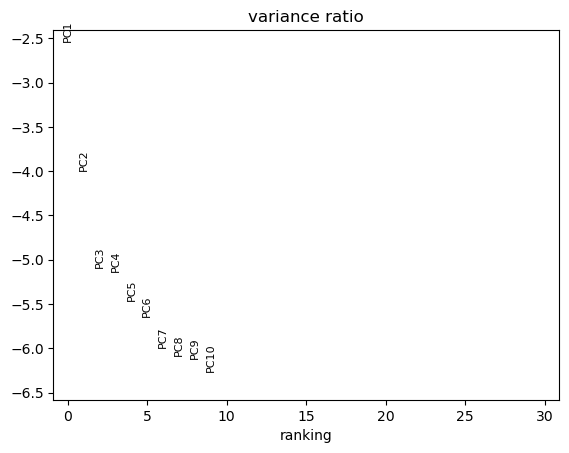

In [59]:
# work on tmp copy
adata_neurons_tmp = sn_neuronal_full_ad.copy()

adata_neurons_tmp.layers["counts"] = adata_neurons_tmp.X.copy()  # type: ignore

sc.pp.normalize_total(adata_neurons_tmp, target_sum=1e4)
sc.pp.log1p(adata_neurons_tmp)

hvgs_full = sc.experimental.pp.highly_variable_genes(
        adata_neurons_tmp,
        n_top_genes=3000,
        batch_key="dataset_id",
        flavor="pearson_residuals",
        check_values=True,
        layer="counts",
        subset=False,
        inplace=False
)
    
# PCA for QC diagnostics
sc.tl.pca(adata_neurons_tmp, svd_solver="arpack", n_comps=10)
sc.pl.pca_variance_ratio(adata_neurons_tmp, log=True)

# Neighborhood graph using scVI embedding
sc.pp.neighbors(adata_neurons_tmp, use_rep="X_scVI", n_neighbors=15)

# Leiden clustering at multiple resolutions for robustness
for res in [0.5, 1.0, 1.5]:
    sc.tl.leiden(adata_neurons_tmp, resolution=res, key_added=f"leiden_sn_scVI_{res}")

# Working resolution
cluster_key = "leiden_sn_scVI_1.0"


In [64]:
# Score DA neuron markers
# validate presence of marker genes
marker_genes = ["TH", "DDC", "SLC6A3", "NR4A2", "SLC18A2"]
for g in marker_genes:
    assert g in adata_neurons_tmp.var_names, f"{g} not found in var_names!"
existing_markers = [g for g in marker_genes if g in adata_neurons_tmp.var_names]
sc.tl.score_genes(adata_neurons_tmp, existing_markers, score_name="DA_score")

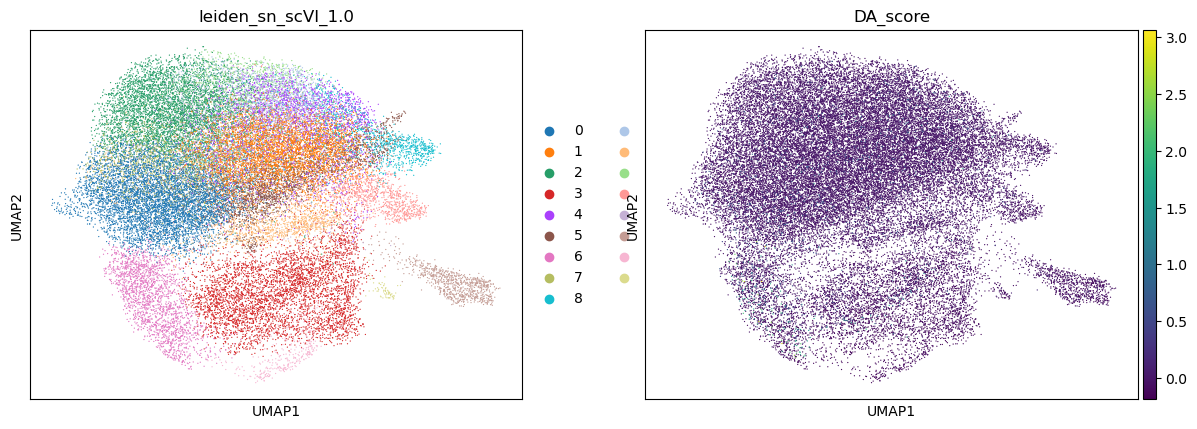

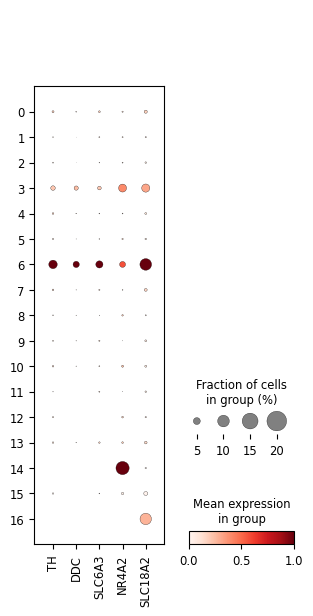

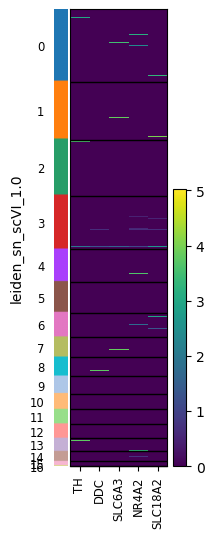

In [65]:
# UMAP from scVI neighbors
sc.tl.umap(adata_neurons_tmp)

# UMAP overlays: clusters and DA score
sc.pl.umap(adata_neurons_tmp, color=[cluster_key, "DA_score"], cmap="viridis")

# Dotplot and heatmap for DA markers across clusters
sc.pl.dotplot(adata_neurons_tmp, existing_markers, groupby=cluster_key, standard_scale="var")
sc.pl.heatmap(adata_neurons_tmp, existing_markers, groupby=cluster_key, use_raw=False)


/tmp/ipykernel_3321/1210352497.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


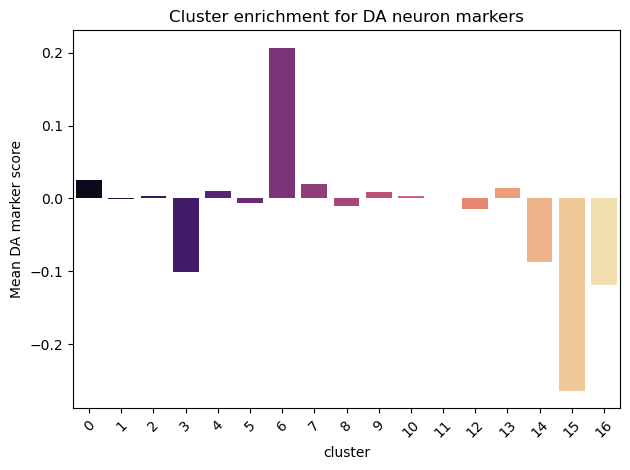

In [67]:
sns.barplot(
    data=cluster_means.reset_index().rename(columns={cluster_key: "cluster"}),
    x="cluster",
    y="DA_score",
    palette="magma"
)
plt.xticks(rotation=45)
plt.ylabel("Mean DA marker score")
plt.title("Cluster enrichment for DA neuron markers")
plt.tight_layout()
plt.show()